# Working with tabular data in Python

One of the foundational parts of any astronomical data analysis workflow is the input, output, and manipulation of tables of data.  This can range from collating the results of other analysis to downloading/exploring large catalogs of data to formatting LaTeX tables in manuscripts for publication.  The Python ecosystem provides a number of powerful tools for doing this.  The most popular of these is Pandas (http://pandas.pydata.org) which has become very widely used in science in general.  The ``astropy.io.*`` modules provide a set of utilities for handling a wide variety of ASCII (e.g. CSV, ECSV) and binary (e.g. FITS, HDF5) data types. AstroPy's [Table](http://docs.astropy.org/en/stable/table/index.html) provides support for manipulating heterogeneous data tables and integrates with AstroPy's [Units and Quantities](http://astropy.readthedocs.org/en/stable/units/index.html) functionality. 

A more in-depth look at AstroPy Table and what it can do will be given on Thursday by Tom Aldcroft. This tutorial will focus more on Pandas and how it can interoperate with AstroPy functionality.

In [1]:
# generic imports
import numpy as np
import matplotlib
from matplotlib import style
style.use('ggplot')  
matplotlib.use('nbagg')  # required for interactive plotting
import matplotlib.pyplot as plt

## Getting started with Pandas

A great introduction to Pandas functionality is the [10 Minutes to Pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html) tutorial. A complementary Jupyter notebook that covers Pandas basics in detail can be found [here](https://github.com/donnemartin/data-science-ipython-notebooks/blob/master/pandas/pandas.ipynb). 

There are also a number of astronomy-oriented tutorials that feature Pandas:

* Jane Rigby is setting up a one-stop shop for such tutorials/examples at https://github.com/janerigby/astro-pandas-tutorials.
* Michael Gully-Santiago has some examples of using Pandas to explore Gaia data at https://github.com/gully/adrasteia.
* A trove of brown dwarf research-related Jupyter notebooks, many of which featuring Pandas, can be found at https://github.com/BrownDwarf/ApJdataFrames. 

This tutorial borrows heavily from these resources and will emphasize how to quickly get from input data to real scientific analysis using Pandas and AstroPy.

In [2]:
import pandas as pd  # this is the accepted convention for importing pandas, much as np is the convention for numpy

Reading in basic ASCII data is straightforward using the ``read_table()`` and ``read_csv()`` methods:

In [3]:
# read in some background data courtest of Jane Rigby
bkgd = pd.read_table("data/zody_and_ism.txt", comment='#', delim_whitespace=True)
bkgd.head()

,wave,zody,ISM
0,0.5,0.130794,0.000470
1,0.6,0.167639,0.000725
2,0.7,0.171173,0.001048
3,0.8,0.160736,0.001440
4,0.9,0.150599,0.001907


In [4]:
bkgd['ISM'].head()

0    0.000470
1    0.000725
2    0.001048
3    0.001440
4    0.001907
Name: ISM, dtype: float64

For quick-n-dirty data exploration, the ability to plot directly from DataFrame objects is very handy. Especially when coupled with the ``nbagg`` interactive backend which allows you to pan and zoom:

<IPython.core.display.Javascript object>


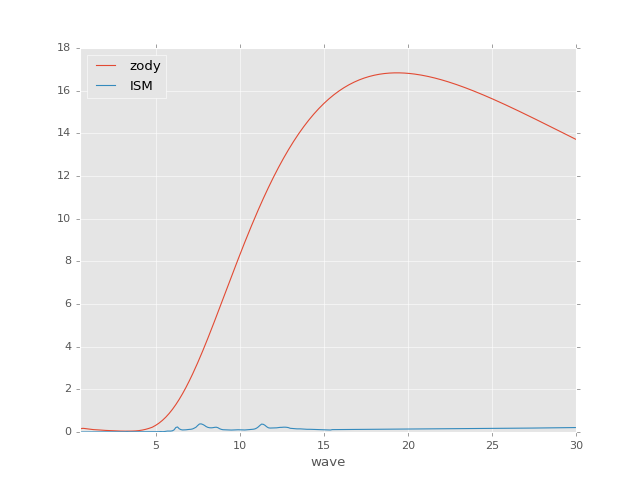

In [5]:
bkgd.plot(x='wave')
plt.show()

In [6]:
bkgd.plot?

<IPython.core.display.Javascript object>


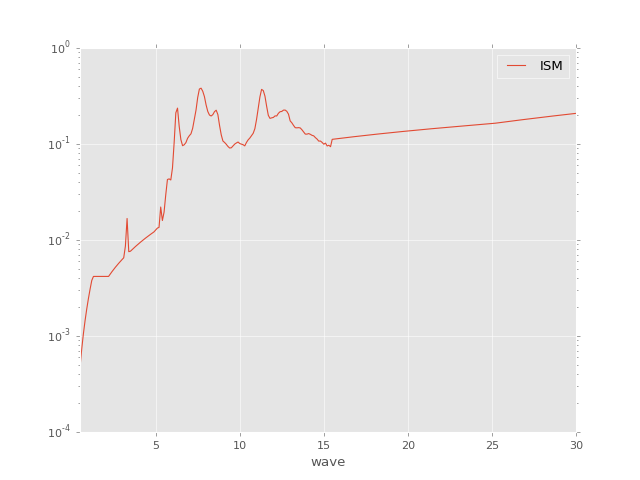

In [7]:
bkgd.plot(x='wave', y='ISM', logy=True)
plt.show()

We can read another background component from another file and incorporate it into our DataFrame using ``merge()``:

In [8]:
thermal_bg = pd.read_csv("data/thermal_curve_jwst_jrigby_1.1.csv", comment="#", names=("wave", "thermal"))
thermal_bg.head()

,wave,thermal
0,5.0,0.000049
1,5.1,0.000069
2,5.2,0.000096
3,5.3,0.000131
4,5.4,0.000178


<IPython.core.display.Javascript object>


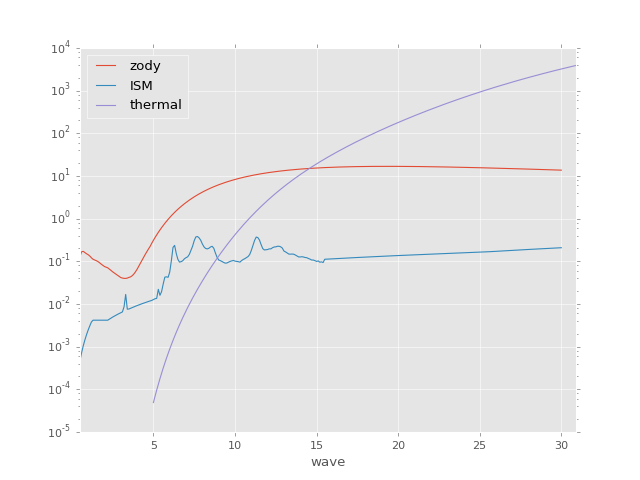

In [9]:
bg_merge = pd.merge(bkgd, thermal_bg, on='wave', how='outer')  # keep all data...
bg_merge.plot(x='wave', logy=True)
plt.show()

In [10]:
bg_merge.head()

,wave,zody,ISM,thermal
0,0.5,0.130794,0.000470,NaN
1,0.6,0.167639,0.000725,NaN
2,0.7,0.171173,0.001048,NaN
3,0.8,0.160736,0.001440,NaN
4,0.9,0.150599,0.001907,NaN


In [11]:
bg_merge[275:280]

,wave,zody,ISM,thermal
275,28.0,14.503131,0.189905,2041.0
276,28.1,14.464021,0.190823,2091.0
277,28.2,14.424856,0.191742,2141.0
278,28.3,14.385640,0.192662,2193.0
279,28.4,14.346379,0.193584,2246.0


In [12]:
bg_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 0 to 304
Data columns (total 4 columns):
wave       305 non-null float64
zody       296 non-null float64
ISM        296 non-null float64
thermal    260 non-null float64
dtypes: float64(4)
memory usage: 11.9 KB


### Exercise

Make a new column that is the sum of the background components and plot the results. (HINT: It's really easy! Access each column by name like with a dict...)

In [ ]:
# %load solution1.py

## More complicated data formats

[``astropy.io.ascii``](http://docs.astropy.org/en/stable/io/ascii/index.html) provides support for a wide variety of ASCII formats, including many astronomy-specific ones. These include:

* Basic: basic table with customizable delimiters and header configurations
* Cds: CDS format table (also Vizier and ApJ machine readable tables)
* Daophot: table from the IRAF DAOphot package
* Ecsv: Enhanced CSV format
* FixedWidth: table with fixed-width columns (see also Fixed-width Gallery)
* Ipac: IPAC format table
* HTML: HTML format table contained in a ``<table>`` tag
* Latex: LaTeX table with datavalue in the tabular environment
* Rdb: tab-separated values with an extra line after the column definition line
* SExtractor: SExtractor format table

The reader is also fairly smart and can auto-detect many of these formats.  Here's an example using a table from an ApJ paper (courtesty Jane Rigby):

In [14]:
!head -100 data/apjsaa2f41t6_mrt.txt

Title: The Metal Abundances Across Cosmic Time (MACT) Survey I: 
       Optical Spectroscopy In The Subaru Deep Field  
Authors: Ly C., Malhotra S., Malkan M.A., Rigby J.R., Kashikawa N., 
         de los Reyes M.A., Rhoads J.E. 
Table: Strong Nebular Emission Lines for the [O III] 4363A-detected Sample
Byte-by-byte Description of file: apjsaa2f41t6_mrt.txt
--------------------------------------------------------------------------------
   Bytes Format Units          Label     Explanations
--------------------------------------------------------------------------------
   1-  6 A6     ---            ID        Object identifier
       8 A1     ---          l_O2-3727   The 3{sigma} upper limit flag
                                          on OII-3727
   9- 13 F5.2   ---            O2-3727   The [O II] 3727A line emission (1)
  15- 18 F4.2   ---          e_O2-3727   ? Uncertainty in O2-3727 
  20- 22 A3     ---          f_O2-3727   Flag on O2-3727 (2)
      24 A1     ---          l_Ne3-3

In [19]:
from astropy.io import ascii
table = ascii.read("data/apjsaa2f41t6_mrt.txt")
table.show_in_notebook()

idx,ID,l_O2-3727,O2-3727,e_O2-3727,f_O2-3727,l_Ne3-3869,Ne3-3869,e_Ne3-3869,f_Ne3-3869,l_Ne3-3967,Ne3-3967,e_Ne3-3967,f_Ne3-3967,l_Hd,Hd,e_Hd,f_Hd,Hg,e_Hg,f_Hg,l_O3-4363,O3-4363,e_O3-4363,f_O3-4363,Hb,e_Hb,f_Hb,O3-4959,e_O3-4959,f_O3-4959,O3-5007,e_O3-5007,f_O3-5007,Ha,e_Ha,f_Ha,l_S2-6717,S2-6717,e_S2-6717,f_S2-6717,l_S2-6731,S2-6731,e_S2-6731,f_S2-6731
,,,,,,,,,,,,,,,,,,,,,,,,,[10-17mW/m2],[10-17mW/m2],,,,,,,,,,,,,,,,,,
0,MK01,--,2.4,0.01,b,--,0.41,0.01,b,--,0.2,0.01,b,--,0.26,0.01,b,0.51,0.01,b,--,0.069,0.007,b,21.74,0.08,a,1.53,--,a,4.77,--,a,3.04,--,a,--,0.28,0.01,a,--,0.3,0.01,a
1,MK02,--,1.73,0.01,b,--,0.34,0.01,b,--,0.22,--,b,--,0.23,--,b,0.39,--,a,--,0.033,0.003,a,68.0,0.17,a,1.47,--,a,4.54,--,a,2.43,0.01,"d,a",--,0.13,--,a,--,0.09,--,a
2,MK03,--,0.64,0.03,b,--,0.5,0.03,b,--,0.23,0.03,b,--,0.21,0.03,b,0.45,0.03,b,--,0.123,0.019,a,4.91,0.07,a,2.35,0.01,a,6.65,0.01,a,2.75,0.02,a,<,0.05,--,a,<,0.05,--,a
3,MK04,--,1.68,0.03,b,--,0.39,0.02,b,--,0.23,0.02,b,--,0.27,0.01,a,0.53,0.01,a,--,0.074,0.006,a,19.96,0.09,a,1.95,--,"d,a",5.92,--,a,3.06,--,a,--,0.16,0.01,a,--,--,--,--
4,MMT01,--,1.23,0.02,--,--,0.4,0.02,--,--,0.22,0.02,--,--,0.2,0.02,d,0.4,0.02,--,--,0.152,0.022,--,10.17,0.3,--,1.92,0.03,--,5.61,0.02,--,--,--,--,--,--,--,--,--,--,--,--
5,MMT02,--,2.82,0.03,--,--,0.25,0.02,--,<,0.05,--,--,--,0.24,0.02,--,0.38,0.02,--,--,0.042,0.014,--,7.55,0.15,--,1.04,0.02,--,2.9,0.02,--,--,--,--,--,--,--,--,--,--,--,--
6,MMT03,--,3.68,0.06,--,--,0.24,0.04,--,<,0.0,--,--,--,0.26,0.02,--,0.46,0.02,--,--,0.102,0.028,--,5.71,0.17,--,0.51,0.04,--,1.58,0.03,--,--,--,--,--,--,--,--,--,--,--,--
7,MMT05,--,0.55,0.03,--,--,0.49,0.03,--,--,0.35,0.03,--,--,0.21,0.03,--,0.49,0.03,--,--,0.145,0.023,--,6.87,0.06,a,2.46,0.01,a,6.88,0.01,a,2.79,0.01,a,<,0.02,--,a,<,0.03,--,a
8,MMT07,--,1.09,0.01,--,--,0.44,0.01,--,--,0.27,0.01,--,--,0.2,0.01,--,0.5,0.01,--,--,0.13,0.01,d,17.6,0.09,a,1.93,0.01,a,6.03,--,a,3.37,--,a,--,0.12,0.01,a,--,0.09,0.01,a


``ascii.read()`` returns an [``astropy.table.Table``](http://docs.astropy.org/en/stable/io/ascii/index.html) instance! We'll come back to cover ``Table`` in more detail. For now we'll take advantage of the ``to_pandas()`` method to convert the table into a pandas DataFrame:

In [38]:
df = table.to_pandas()
df.head()

,ID,l_O2-3727,O2-3727,e_O2-3727,f_O2-3727,l_Ne3-3869,Ne3-3869,e_Ne3-3869,f_Ne3-3869,l_Ne3-3967,...,e_Ha,f_Ha,l_S2-6717,S2-6717,e_S2-6717,f_S2-6717,l_S2-6731,S2-6731,e_S2-6731,f_S2-6731
0,MK01,NaN,2.40,0.01,b,NaN,0.41,0.01,b,NaN,...,NaN,a,NaN,0.28,0.01,a,NaN,0.30,0.01,a
1,MK02,NaN,1.73,0.01,b,NaN,0.34,0.01,b,NaN,...,0.01,"d,a",NaN,0.13,NaN,a,NaN,0.09,NaN,a
2,MK03,NaN,0.64,0.03,b,NaN,0.50,0.03,b,NaN,...,0.02,a,<,0.05,NaN,a,<,0.05,NaN,a
3,MK04,NaN,1.68,0.03,b,NaN,0.39,0.02,b,NaN,...,NaN,a,NaN,0.16,0.01,a,NaN,NaN,NaN,NaN
4,MMT01,NaN,1.23,0.02,NaN,NaN,0.40,0.02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df.mean()

O2-3727        1.694091
e_O2-3727      0.043692
Ne3-3869       0.372576
e_Ne3-3869     0.032188
Ne3-3967       0.194407
e_Ne3-3967     0.031190
Hd             0.238788
e_Hd           0.023559
Hg             0.460606
e_Hg           0.025538
O3-4363        0.112773
e_O3-4363      0.023908
Hb            11.119394
e_Hb           0.138333
O3-4959        1.527727
e_O3-4959      0.023226
O3-5007        4.551970
e_O3-5007      0.023443
Ha             3.027812
e_Ha           0.032500
S2-6717        0.265333
e_S2-6717      0.028182
S2-6731        0.188571
e_S2-6731      0.018889
dtype: float64

In [40]:
df.describe()

,O2-3727,e_O2-3727,Ne3-3869,e_Ne3-3869,Ne3-3967,e_Ne3-3967,Hd,e_Hd,Hg,e_Hg,...,O3-4959,e_O3-4959,O3-5007,e_O3-5007,Ha,e_Ha,S2-6717,e_S2-6717,S2-6731,e_S2-6731
count,66.000000,65.000000,66.000000,64.000000,59.000000,42.000000,66.000000,59.000000,66.000000,65.000000,...,66.000000,62.000000,66.000000,61.000000,32.000000,28.000000,30.000000,22.000000,28.000000,18.000000
mean,1.694091,0.043692,0.372576,0.032188,0.194407,0.031190,0.238788,0.023559,0.460606,0.025538,...,1.527727,0.023226,4.551970,0.023443,3.027813,0.032500,0.265333,0.028182,0.188571,0.018889
std,0.851097,0.036851,0.126324,0.026032,0.118529,0.023395,0.077171,0.016893,0.134974,0.019687,...,0.464148,0.018710,1.482068,0.018063,0.363378,0.041866,0.220231,0.040076,0.125719,0.012783
min,0.090000,0.010000,0.080000,0.010000,0.000000,0.010000,0.000000,0.010000,0.290000,0.010000,...,0.470000,0.010000,1.330000,0.010000,2.220000,0.010000,0.020000,0.010000,0.030000,0.010000
25%,1.170000,0.020000,0.312500,0.010000,0.080000,0.010000,0.200000,0.010000,0.400000,0.010000,...,1.257500,0.010000,3.715000,0.010000,2.847500,0.010000,0.130000,0.010000,0.090000,0.010000
50%,1.600000,0.030000,0.380000,0.025000,0.220000,0.025000,0.240000,0.020000,0.440000,0.020000,...,1.545000,0.020000,4.590000,0.020000,3.050000,0.020000,0.230000,0.020000,0.150000,0.010000
75%,2.312500,0.060000,0.440000,0.040000,0.270000,0.047500,0.270000,0.030000,0.490000,0.030000,...,1.862500,0.030000,5.542500,0.030000,3.225000,0.030000,0.297500,0.030000,0.267500,0.020000
max,3.680000,0.210000,0.780000,0.150000,0.510000,0.110000,0.490000,0.100000,1.370000,0.090000,...,2.460000,0.110000,9.330000,0.100000,4.210000,0.200000,0.980000,0.200000,0.520000,0.050000


For data like this, we can reset the index to be the ``ID`` so that we can more easily access data for specific objects:

In [41]:
df.set_index('ID', inplace=True)

In [43]:
df.head()

,l_O2-3727,O2-3727,e_O2-3727,f_O2-3727,l_Ne3-3869,Ne3-3869,e_Ne3-3869,f_Ne3-3869,l_Ne3-3967,Ne3-3967,...,e_Ha,f_Ha,l_S2-6717,S2-6717,e_S2-6717,f_S2-6717,l_S2-6731,S2-6731,e_S2-6731,f_S2-6731
ID,,,,,,,,,,,,,,,,,,,,,
MK01,NaN,2.40,0.01,b,NaN,0.41,0.01,b,NaN,0.20,...,NaN,a,NaN,0.28,0.01,a,NaN,0.30,0.01,a
MK02,NaN,1.73,0.01,b,NaN,0.34,0.01,b,NaN,0.22,...,0.01,"d,a",NaN,0.13,NaN,a,NaN,0.09,NaN,a
MK03,NaN,0.64,0.03,b,NaN,0.50,0.03,b,NaN,0.23,...,0.02,a,<,0.05,NaN,a,<,0.05,NaN,a
MK04,NaN,1.68,0.03,b,NaN,0.39,0.02,b,NaN,0.23,...,NaN,a,NaN,0.16,0.01,a,NaN,NaN,NaN,NaN
MMT01,NaN,1.23,0.02,NaN,NaN,0.40,0.02,NaN,NaN,0.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.ix['MMT10']

l_O2-3727       NaN
O2-3727        1.36
e_O2-3727      0.02
f_O2-3727       NaN
l_Ne3-3869      NaN
Ne3-3869       0.37
e_Ne3-3869     0.01
f_Ne3-3869      NaN
l_Ne3-3967      NaN
Ne3-3967       0.14
e_Ne3-3967     0.01
f_Ne3-3967      NaN
l_Hd            NaN
Hd             0.26
e_Hd           0.01
f_Hd            NaN
Hg             0.44
e_Hg           0.01
f_Hg            NaN
l_O3-4363       NaN
O3-4363       0.089
e_O3-4363     0.008
f_O3-4363       NaN
Hb            20.93
e_Hb           0.16
f_Hb            NaN
O3-4959        1.69
e_O3-4959      0.01
f_O3-4959       NaN
O3-5007        5.11
e_O3-5007      0.01
f_O3-5007       NaN
Ha             3.09
e_Ha           0.01
f_Ha            NaN
l_S2-6717       NaN
S2-6717        0.16
e_S2-6717      0.01
f_S2-6717       NaN
l_S2-6731       NaN
S2-6731        0.12
e_S2-6731      0.01
f_S2-6731       NaN
Name: MMT10, dtype: object

## Exercise

Create a new column that contains the [O III] 4363/5007 flux ratio and plot the flux ratio vs. [O III] 5007 flux. 

(HINT: Look in the header of the data file shown above for descriptions of the columns and use the ``kind='scatter'`` argument in the ``plot()`` command)

In [ ]:
# %load solution2.py

Now we can use this new column to make a mask to define a subset of the data with stronger 4363 line strength relative to 5007:

In [50]:
mask = df['O3_4363/5007'].gt(df['O3_4363/5007'].median())
subset = df[mask].copy()
subset.describe()

,O2-3727,e_O2-3727,Ne3-3869,e_Ne3-3869,Ne3-3967,e_Ne3-3967,Hd,e_Hd,Hg,e_Hg,...,O3-5007,e_O3-5007,Ha,e_Ha,S2-6717,e_S2-6717,S2-6731,e_S2-6731,O3_ratio,O3_4363/5007
count,33.000000,32.000000,33.000000,31.000000,29.000000,18.000000,33.000000,29.000000,33.000000,33.000000,...,33.000000,32.000000,16.000000,15.000000,15.000000,9.000000,13.000000,6.000000,33.000000,33.000000
mean,1.573030,0.058438,0.373333,0.043226,0.212414,0.040000,0.250303,0.031034,0.486970,0.034848,...,4.244545,0.028438,3.031875,0.045333,0.288667,0.044444,0.193846,0.023333,0.039155,0.039155
std,0.997386,0.032736,0.136717,0.030264,0.125062,0.022229,0.095115,0.019336,0.180407,0.023200,...,1.485126,0.020018,0.405828,0.053701,0.286802,0.059815,0.159924,0.017512,0.015313,0.015313
min,0.090000,0.010000,0.160000,0.010000,0.000000,0.010000,0.000000,0.010000,0.290000,0.010000,...,1.330000,0.010000,2.460000,0.010000,0.020000,0.010000,0.030000,0.010000,0.020935,0.020935
25%,1.070000,0.037500,0.260000,0.030000,0.080000,0.030000,0.200000,0.020000,0.400000,0.020000,...,3.580000,0.020000,2.827500,0.020000,0.115000,0.010000,0.070000,0.010000,0.026744,0.026744
50%,1.280000,0.055000,0.380000,0.040000,0.240000,0.035000,0.250000,0.030000,0.470000,0.030000,...,4.470000,0.020000,2.975000,0.030000,0.180000,0.030000,0.120000,0.015000,0.036422,0.036422
75%,2.340000,0.072500,0.460000,0.050000,0.280000,0.050000,0.280000,0.040000,0.510000,0.040000,...,5.170000,0.030000,3.157500,0.040000,0.310000,0.040000,0.290000,0.035000,0.047321,0.047321
max,3.680000,0.150000,0.730000,0.150000,0.450000,0.110000,0.490000,0.100000,1.370000,0.090000,...,7.270000,0.100000,4.210000,0.200000,0.980000,0.200000,0.520000,0.050000,0.080353,0.080353


Masks can be combined logically to make more sophisticated filtering possible:

In [64]:
mask2 = df['f_O3-4363'] != 'd'  # exclude where 4363 line is contaminated by sky emission
subset2 = df[mask & mask2].copy()  # combine with the previous mask to make a new subset with cleaner 4363
subset2.describe()

,O2-3727,e_O2-3727,Ne3-3869,e_Ne3-3869,Ne3-3967,e_Ne3-3967,Hd,e_Hd,Hg,e_Hg,...,O3-5007,e_O3-5007,Ha,e_Ha,S2-6717,e_S2-6717,S2-6731,e_S2-6731,O3_ratio,O3_4363/5007
count,28.000000,28.000000,28.000000,26.000000,24.000000,15.000000,28.000000,24.000000,28.000000,28.00000,...,28.000000,28.000000,14.000000,14.000000,13.000000,7.000000,11.000000,5.000000,28.000000,28.000000
mean,1.662143,0.061786,0.384286,0.046923,0.208333,0.042000,0.252500,0.033333,0.451786,0.03500,...,4.217857,0.030000,3.048571,0.044286,0.266923,0.027143,0.182727,0.026000,0.039861,0.039861
std,1.009922,0.032552,0.138147,0.031594,0.130039,0.022741,0.101821,0.019927,0.081425,0.02269,...,1.485214,0.020905,0.394693,0.055569,0.275874,0.013801,0.156083,0.018166,0.015504,0.015504
min,0.260000,0.020000,0.160000,0.010000,0.000000,0.020000,0.000000,0.010000,0.290000,0.01000,...,1.330000,0.010000,2.560000,0.010000,0.020000,0.010000,0.030000,0.010000,0.020935,0.020935
25%,1.130000,0.040000,0.297500,0.030000,0.077500,0.030000,0.207500,0.020000,0.400000,0.02000,...,3.505000,0.020000,2.845000,0.020000,0.110000,0.015000,0.060000,0.010000,0.027007,0.027007
50%,1.300000,0.060000,0.395000,0.040000,0.230000,0.040000,0.255000,0.030000,0.460000,0.03000,...,4.395000,0.030000,2.975000,0.025000,0.180000,0.030000,0.120000,0.020000,0.036632,0.036632
75%,2.405000,0.080000,0.475000,0.050000,0.275000,0.050000,0.282500,0.040000,0.492500,0.04000,...,5.080000,0.032500,3.117500,0.030000,0.290000,0.040000,0.255000,0.040000,0.048937,0.048937
max,3.680000,0.150000,0.730000,0.150000,0.450000,0.110000,0.490000,0.100000,0.640000,0.09000,...,7.270000,0.100000,4.210000,0.200000,0.980000,0.040000,0.520000,0.050000,0.080353,0.080353


## Binary tables

Pandas has native support for binary tables in HDF5 and even Excel format. However, it does not support the most popular binary format used in astronomy, FITS.  

Again, AstroPy ``Table`` can be used as a bridge:

In [66]:
from astropy.table import Table

In [70]:
fits_df = Table.read("data/cdfs_obs_sources.fits").to_pandas()
fits_df.head()

,obsid,obi,targname,gti_obs,flux_aper_b,src_cnts_aper_b,ra_b,dec_b,livetime,posid,theta,msid
0,441,0,AXAF Southern Deep Field - AC...,2000-05-27T01:32:52,1.016000e-14,53.492,03 32 50.25,-27 52 52.60,55967.0,14983,6.883,33150
1,441,0,AXAF Southern Deep Field - AC...,2000-05-27T01:32:52,1.640000e-14,112.290,03 32 37.77,-27 52 12.63,55967.0,14984,4.569,33164
2,441,0,AXAF Southern Deep Field - AC...,2000-05-27T01:32:52,6.472000e-15,43.247,03 32 43.22,-27 49 14.77,55967.0,14985,3.723,33183
3,441,0,AXAF Southern Deep Field - AC...,2000-05-27T01:32:52,1.304000e-14,69.774,03 32 59.85,-27 47 48.72,55967.0,14986,7.302,33198
4,441,0,AXAF Southern Deep Field - AC...,2000-05-27T01:32:52,8.389000e-14,594.610,03 32 08.67,-27 47 34.83,55970.2,14987,4.101,33202


In [71]:
fits_df.describe()

,obsid,obi,flux_aper_b,src_cnts_aper_b,livetime,posid,theta,msid
count,1637.000000,1637.000000,1.637000e+03,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,5436.938302,0.153329,1.103763e-14,86.442646,94942.505559,21768.261454,6.386819,32863.598656
std,3635.846647,0.360415,1.887082e-14,172.552070,34700.613302,10974.485248,2.526426,12539.799769
min,441.000000,0.000000,1.163000e-16,4.670900,29683.200000,14983.000000,0.697000,11567.000000
25%,2312.000000,0.000000,2.994000e-15,22.474000,59280.700000,15665.000000,4.424000,33137.000000
50%,8591.000000,0.000000,5.291000e-15,37.875000,108700.600000,16363.000000,6.477000,33160.000000
75%,8596.000000,0.000000,1.035000e-14,74.876000,130398.600000,17964.000000,7.845000,33189.000000
max,9718.000000,1.000000,1.496000e-13,1735.100000,141416.000000,44629.000000,18.106000,148108.000000


When loading FITS tables, it's recommended to use the high-level ``Table`` interface rather than the lower level ``astropy.io.fits`` interface unless you really know what you're doing.  The ``Table`` I/O interface automatically handles the endianness of the data and converts accordingly, as needed. 

# Tables vs DataFrames

